In [108]:
# =============================================================================
# 1) Imports & Global Configuration
#    (2025 Production-Ready — Clean, Deterministic, Robust)
# =============================================================================

from __future__ import annotations

import warnings
import random
from pathlib import Path
from typing import Final

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

# --- Scikit-learn -------------------------------------------------------------
from sklearn import set_config
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    auc,
    average_precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- XGBoost / Imbalanced-learn ------------------------------------------------
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# =============================================================================
# Global Configuration
# =============================================================================

RANDOM_STATE: Final[int] = 42
SEED: Final[int] = RANDOM_STATE

# Ensure deterministic behavior
np.random.seed(SEED)
random.seed(SEED)

# Scikit-learn settings
set_config(transform_output="pandas")  # Maintain DataFrame outputs
# Removed: enable_metadata_routing=True (deprecated in sklearn >=1.4)

# Suppress warnings (kept intentionally narrow and controlled)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=UserWarning, module="imblearn")
# Removed shap UserWarning suppression — SHAP warnings often indicate real issues

# Plotting configuration
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.05)

plt.rcParams.update(
    {
        "figure.dpi": 130,
        "figure.figsize": (10, 6),
        "axes.grid": True,
        "grid.alpha": 0.3,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"],
        "legend.frameon": True,
        "legend.framealpha": 0.95,
        "savefig.bbox": "tight",
        "savefig.dpi": 300,
    }
)

print("Global imports and configuration loaded successfully.")
print("=" * 88)


Global imports and configuration loaded successfully.


In [109]:
# =============================================================================
# 2) Load Raw Data
#    (Production-Ready, 2025)
# =============================================================================

from pathlib import Path
from typing import Final
import pandas as pd

# Optional but recommended for preview in notebooks
try:
    from IPython.display import display
except ImportError:
    display = print  # Fallback for .py execution

# -----------------------------------------------------------------------------
# File Path Configuration
# -----------------------------------------------------------------------------
DATA_DIR: Final[Path] = Path(__file__).parent if "__file__" in globals() else Path.cwd()
DATA_PATH: Final[Path] = DATA_DIR / "PlayerData.xlsx"

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"PlayerData.xlsx not found at: {DATA_PATH.resolve()}"
    )

print(f"Loading dataset: {DATA_PATH.name}")

# -----------------------------------------------------------------------------
# Load Dataset
# -----------------------------------------------------------------------------
df_raw = pd.read_excel(
    DATA_PATH,
    engine="openpyxl",
    dtype={"Index Number": "Int64", "Season": str},
    na_values=["", "NA", "#N/A", "N/A", "NULL", "null"],
)

# -----------------------------------------------------------------------------
# Dataset Summary
# -----------------------------------------------------------------------------
print("\n" + "DATASET LOADED".center(80, "="))

n_rows = len(df_raw)
n_cols = len(df_raw.columns)
memory_mb = df_raw.memory_usage(deep=True).sum() / 1e6

print(f"{'Rows':<18}: {n_rows:,}")
print(f"{'Columns':<18}: {n_cols:,}")
print(f"{'Shape':<18}: {df_raw.shape}")
print(f"{'Memory Usage':<18}: {memory_mb:.2f} MB")

# High-level categorical information
if "Season" in df_raw.columns:
    print(f"{'Seasons':<18}: {sorted(df_raw['Season'].dropna().unique())}")

if "Index Number" in df_raw.columns:
    print(f"{'Unique Players':<18}: {df_raw['Index Number'].nunique():,}")

if "Stick_NBA" in df_raw.columns:
    stick_rate = df_raw["Stick_NBA"].mean()
    stick_count = df_raw["Stick_NBA"].sum()
    print(f"{'Stick_NBA Rate':<18}: {stick_rate:.3%} ({stick_count:,})")

# -----------------------------------------------------------------------------
# Missing Values Report
# -----------------------------------------------------------------------------
missing = df_raw.isna().mean().round(4)

if missing.any():
    missing_nonzero = missing[missing > 0]
    if not missing_nonzero.empty:
        print("\nMissing Values (Top 10):")
        print(
            missing_nonzero.sort_values(ascending=False)
            .head(10)
            .to_string(float_format="{:>6.1%}".format)
        )
    else:
        print("\nNo missing values detected.")
else:
    print("\nNo missing values detected.")

# -----------------------------------------------------------------------------
# Preview Sample
# -----------------------------------------------------------------------------
print("\nFirst 5 rows:")
display(
    df_raw.head().style.set_table_styles(
        [{"selector": "tr:hover", "props": "background-color: #f5f5f5;"}]
    )
)

print("═" * 88)


Loading dataset: PlayerData.xlsx

=================================DATASET LOADED=================================
Rows              : 37,967
Columns           : 82
Shape             : (37967, 82)
Memory Usage      : 36.11 MB
Seasons           : ['2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
Unique Players    : 15,236
Stick_NBA Rate    : 0.861% (327)

Missing Values (Top 10):
3P_percent      4.6%
FT_percent      0.5%
2P_percent      0.0%
ORB_percent     0.0%
BLK_percent     0.0%
STL_percent     0.0%
AST_percent     0.0%
TRB_percent     0.0%
DRB_percent     0.0%
WS40            0.0%

First 5 rows:


,Index Number,Index Name,Player,Years in College,Pos,Pos Numeric,Class,Class Numeric,HT,WT,PTS,Season,Team,Conference Rank,G,GS,MP,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,FG_percent,2P_percent,3P_percent,FT_percent,TS_percent,eFG_percent,FG_per40,FGA_per40,2P_per40,2PA_per40,3P_per40,3PA_per40,FT_per40,FTA_per40,ORB_per40,DRB_per40,TRB_per40,AST_per40,STL_per40,BLK_per40,TOV_per40,PF_per40,PTS_per40,WS,ORtg,DRtg,OWS,DWS,WS40,OBPM,DBPM,BPM,PER,ORB_percent,DRB_percent,TRB_percent,AST_percent,STL_percent,BLK_percent,TOV_percent,USG_percent,NBA,Round,Pick,NBA_YOS,NBA_PlusMinus,NBA_AvgMin,NBAMetric,Stick_NBA
0,1,A.C. Reid,A.C. Reid,2,G,1,SO,2,0,0,248,2015-16,Liberty,2,32,12,745,85,236,25,59,60,177,18,25,7,84,91,47,20,4,49,71,0.360000,0.424000,0.339000,0.720000,0.500000,0.487000,4.563758,12.671141,1.342282,3.167785,3.221477,9.503356,0.966443,1.342282,0.375839,4.510067,4.885906,2.523490,1.073826,0.214765,2.630872,3.812081,13.315436,0.700000,91.000000,107.000000,0.000000,0.700000,0.040000,-1.600000,-1.900000,-3.600000,10.100000,1.200000,14.300000,7.900000,13.600000,1.700000,0.700000,16.500000,22.300000,0,0,0,0,0.000000,0.000000,0.000000,0
1,1,A.C. Reid,A.C. Reid,2,G,1,JR,3,0,0,168,2016-17,Liberty,2,35,1,745,85,236,25,59,60,177,18,25,7,84,91,47,20,4,49,71,0.360000,0.424000,0.339000,0.720000,0.500000,0.487000,4.563758,12.671141,1.342282,3.167785,3.221477,9.503356,0.966443,1.342282,0.375839,4.510067,4.885906,2.523490,1.073826,0.214765,2.630872,3.812081,13.315436,0.900000,88.000000,101.000000,-0.200000,1.200000,0.051000,-3.300000,-0.300000,-3.600000,7.300000,0.000000,9.600000,4.700000,16.000000,1.900000,1.000000,17.800000,16.600000,0,0,0,0,0.000000,0.000000,0.000000,0
2,2,A.J. Astroth,A.J. Astroth,2,G,1,JR,3,0,0,180,2016-17,Hampton,3,28,8,514,67,134,64,119,3,15,43,67,58,116,174,18,17,6,26,47,0.500000,0.538000,0.200000,0.642000,0.543000,0.511000,5.214008,10.428016,4.980545,9.260700,0.233463,1.167315,3.346304,5.214008,4.513619,9.027237,13.540856,1.400778,1.322957,0.466926,2.023346,3.657588,14.007782,1.900000,112.000000,97.000000,0.900000,1.000000,0.150000,0.000000,-0.500000,-0.500000,19.200000,12.000000,26.000000,18.800000,7.400000,1.900000,1.300000,13.600000,18.100000,0,0,0,0,0.000000,0.000000,0.000000,0
3,2,A.J. Astroth,A.J. Astroth,2,G,1,SR,4,0,0,19,2017-18,Hampton,3,6,1,514,67,134,64,119,3,15,43,67,58,116,174,18,17,6,26,47,0.500000,0.538000,0.200000,0.642000,0.543000,0.511000,5.214008,10.428016,4.980545,9.260700,0.233463,1.167315,3.346304,5.214008,4.513619,9.027237,13.540856,1.400778,1.322957,0.466926,2.023346,3.657588,14.007782,0.200000,103.000000,97.000000,0.100000,0.100000,0.113000,-8.200000,-0.400000,-8.600000,13.600000,7.600000,22.800000,15.500000,7.200000,1.500000,4.300000,13.100000,15.300000,0,0,0,0,0.000000,0.000000,0.000000,0
4,3,A.J. Avery,A.J. Avery,1,F,3,SR,4,0,0,236,2015-16,Western Michigan,4,32,32,786,85,173,81,164,4,9,62,91,68,122,190,22,23,22,34,105,0.491000,0.494000,0.444000,0.681000,0.546000,0.503000,4.325700,8.804071,4.122137,8.346056,0.203562,0.458015,3.155216,4.631043,3.460560,6.208651,9.669211,1.119593,1.170483,1.119593,1.730280,5.343511,12.010178,2.300000,113.000000,103.000000,1.300000,1.000000,0.118000,-1.200000,0.100000,-1.100000,15.800000,9.700000,18.200000,13.800000,5.700000,1.700000,3.400000,13.600000,16.000000,0,0,0,0,0.000000,0.000000,0.000000,0


════════════════════════════════════════════════════════════════════════════════════════


In [110]:
# =============================================================================
# 3) Feature Engineering
#    (Production-Ready, 2025)
# =============================================================================

import numpy as np
import pandas as pd
from typing import Final

# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------
CFG: Final[dict] = {
    "winsorize_quantile": 0.99,
    "eps": 1e-8,
    "height_ref_inch": 74.0,
}

# -----------------------------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------------------------
def safe_div(a: pd.Series, b: pd.Series | float) -> pd.Series:
    """Elementwise division with numerical stability."""
    return a / (b + CFG["eps"])

def winsorize_series(s: pd.Series, q: float = CFG["winsorize_quantile"]) -> pd.Series:
    """Winsorize a numeric series, skipping low-cardinality or non-numerics."""
    if not np.issubdtype(s.dtype, np.number):
        return s
    if s.nunique() <= 12:
        return s
    tail = (1 - q) / 2
    lo, hi = s.quantile([tail, 1 - tail])
    return s.clip(lower=lo, upper=hi)

# -----------------------------------------------------------------------------
# Feature Engineering Pipeline
# -----------------------------------------------------------------------------
df = df_raw.copy()

print("\n" + " FEATURE ENGINEERING — START ".center(92, "█"))
start_cols = df.shape[1]

# Validate required columns
required = [
    "FTA_per40","FGA_per40","3PA_per40","AST_percent","TOV_percent","USG_percent",
    "STL_percent","BLK_percent","DRB_percent","STL_per40","BLK_per40",
    "PER","BPM","OBPM","DBPM","WS40","Conference Rank","HT","WT","Class Numeric"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# -----------------------------------------------------------------------------
# Core Ratio / Impact Features
# -----------------------------------------------------------------------------
df["FT_rate"] = safe_div(df["FTA_per40"], df["FGA_per40"])
df["Three_Rate"] = safe_div(df["3PA_per40"], df["FGA_per40"])
df["AST_to_TOV"] = safe_div(df["AST_percent"], df["TOV_percent"])
df["AST_to_USG"] = safe_div(df["AST_percent"], df["USG_percent"])
df["Pure_Playmaker"] = df["AST_percent"] - 0.5 * df["USG_percent"]

df["Def_Impact"] = (
    df["STL_percent"] +
    df["BLK_percent"] +
    0.5 * df["DRB_percent"]
)

df["Stocks_per40"] = df["STL_per40"] + df["BLK_per40"]

# -----------------------------------------------------------------------------
# Winsorize Select Advanced Metrics
# -----------------------------------------------------------------------------
for col in ["PER", "BPM", "OBPM", "DBPM", "WS40"]:
    if col in df.columns:
        df[col] = winsorize_series(df[col].fillna(df[col].median()))

# -----------------------------------------------------------------------------
# Synthetic / Composite Metrics
# -----------------------------------------------------------------------------
df["Box_Production"] = (
    0.45 * df["PER"] +
    0.35 * df["BPM"] +
    0.20 * df["WS40"]
)

df["Two_Way_Impact"] = df["OBPM"] + df["DBPM"]
df["Conf_Strength"] = safe_div(1.0, df["Conference Rank"] + 2.0)
df["Conf_Adj_Production"] = df["Box_Production"] * df["Conf_Strength"]

df["Height_Inches"] = df["HT"]

# More accurate proxy name (units = lb / in^2)
df["Mass_to_Height2"] = safe_div(df["WT"], df["HT"] ** 2)

df["Upperclassman"] = (df["Class Numeric"] >= 3).astype(float)

# -----------------------------------------------------------------------------
# Position Dummies
# -----------------------------------------------------------------------------
if "Pos" in df.columns:
    df["Pos"] = df["Pos"].str.strip().str.upper()
    df = pd.concat(
        [df, pd.get_dummies(df["Pos"], prefix="Pos", dtype=float)],
        axis=1
    )

# -----------------------------------------------------------------------------
# NBA Readiness Score
# -----------------------------------------------------------------------------
df["NBA_Ready_Score"] = (
    0.32 * df["Box_Production"] +
    0.18 * df["TS_percent"] +
    0.15 * df["Def_Impact"] +
    0.13 * df["AST_to_TOV"] +
    0.10 * df["Conf_Strength"] +
    0.08 * df["Upperclassman"] +
    0.04 * (df["Height_Inches"] - CFG["height_ref_inch"]).clip(lower=0)
)

# -----------------------------------------------------------------------------
# Cleanup & Final Winsorization
# -----------------------------------------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
float_cols = [c for c in numeric_cols if str(df[c].dtype).startswith("float")]

df[float_cols] = df[float_cols].replace([np.inf, -np.inf], np.nan)

protected = {"PER", "BPM", "OBPM", "DBPM", "WS40", "NBA_Ready_Score", "Upperclassman"}

for col in float_cols:
    if col in protected:
        continue
    if df[col].nunique() <= 12:
        continue
    df[col] = winsorize_series(df[col])

# -----------------------------------------------------------------------------
# Drop Raw Counting Stats
# -----------------------------------------------------------------------------
drop_cols = [
    "G", "GS", "MP", "FG", "FGA", "2P", "2PA", "3P", "3PA", "FT", "FTA",
    "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"
]

df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

# -----------------------------------------------------------------------------
# Summary
# -----------------------------------------------------------------------------
print("\n" + " FEATURE ENGINEERING — COMPLETE ".center(92, "█"))
print(f"  Added features: {df.shape[1] - start_cols:+}")
print(f"  Final shape:    {df.shape[0]:,} × {df.shape[1]}")
print(
    f"  NBA_Ready_Score Range: "
    f"{df['NBA_Ready_Score'].min():.3f} → {df['NBA_Ready_Score'].max():.3f}"
)
print("█" * 92)



███████████████████████████████ FEATURE ENGINEERING — START ████████████████████████████████

██████████████████████████████ FEATURE ENGINEERING — COMPLETE ██████████████████████████████
  Added features: -2
  Final shape:    37,967 × 80
  NBA_Ready_Score Range: -1.374 → 704600008.160
████████████████████████████████████████████████████████████████████████████████████████████


In [111]:
# =============================================================================
# 4) Final Player Aggregation
#    (Production-Ready, 2025) — FINAL & BULLETPROOF
# =============================================================================

import pandas as pd
from typing import Optional


def build_final_player_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct a per-player final dataset using last-season rows, while adding:
      - robust position-aware physical imputation
      - shot volume flags
      - peak metrics
      - safe improvement metrics (handles 1-season players)
      - clean target columns
    """
    df = df.copy()

    # =========================================================================
    # Identify player ID column
    # =========================================================================
    possible_ids = ["Index Number", "Player_ID", "PlayerId", "id"]
    player_id: Optional[str] = next((c for c in possible_ids if c in df.columns), None)
    if player_id is None:
        raise ValueError("No player identifier column found.")
    print(f"Using player ID column: {player_id}")

    rename_back = player_id != "Index Number"
    if rename_back:
        df = df.rename(columns={player_id: "Index Number"})

    # =========================================================================
    # Season handling
    # =========================================================================
    df["Season"] = df["Season"].astype(str).str.strip()
    df["Season_Year"] = df["Season"].str[:4].astype(int)
    df = df.sort_values(["Index Number", "Season_Year"])

    final_year = df.groupby("Index Number")["Season_Year"].transform("max")
    final_df = df[df["Season_Year"] == final_year].copy()

    # =========================================================================
    # Physical attributes — robust hierarchical imputation
    # =========================================================================
    if {"HT", "WT", "Pos"}.issubset(df.columns):
        df["Pos"] = df["Pos"].astype(str).str.upper().str.strip().replace("NAN", pd.NA)

        # 1. Forward-fill known values within player
        df[["HT", "WT", "Pos"]] = df.groupby("Index Number")[["HT", "WT", "Pos"]].ffill()

        # 2. Position-aware medians from known data
        known = df.dropna(subset=["HT", "WT", "Pos"])
        if not known.empty:
            pos_medians = known.groupby("Pos")[["HT", "WT"]].median()
            for pos, row in pos_medians.iterrows():
                mask = (df["Pos"] == pos)
                df.loc[mask & df["HT"].isna(), "HT"] = row["HT"]
                df.loc[mask & df["WT"].isna(), "WT"] = row["WT"]

        # 3. Global fallback
        df["HT"] = df["HT"].fillna(df["HT"].median())
        df["WT"] = df["WT"].fillna(df["WT"].median())

        # Propagate final values to output table
        for col in ["HT", "WT", "Pos"]:
            last_known = df.groupby("Index Number")[col].last()
            final_df[col] = final_df["Index Number"].map(last_known)

    # =========================================================================
    # Shot volume flags
    # =========================================================================
    shot_sources = {
        "3PA_per40": "Ever_3PA",
        "FTA_per40": "Ever_FTA",
        "FGA_per40": "Ever_FGA",
    }
    for src, dest in shot_sources.items():
        if src in df.columns:
            ever = df.groupby("Index Number")[src].max() > 0.5
            final_df[dest] = final_df["Index Number"].map(ever).astype(float)

    # =========================================================================
    # Peak metrics
    # =========================================================================
    peak_cols = [
        "PER", "BPM", "WS40", "TS_percent", "Box_Production",
        "NBA_Ready_Score", "Def_Impact", "AST_to_TOV", "Two_Way_Impact"
    ]
    peak_cols = [c for c in peak_cols if c in df.columns]
    if peak_cols:
        peak_table = (
            df.groupby("Index Number")[peak_cols]
            .max()
            .add_suffix("_peak")
            .reset_index()
        )
        final_df = final_df.merge(peak_table, on="Index Number", how="left")

    # =========================================================================
    # Improvement metrics — safe for single-season players
    # =========================================================================
    imp_cols = ["PER", "BPM", "TS_percent", "Box_Production", "NBA_Ready_Score"]
    imp_cols = [c for c in imp_cols if c in df.columns]

    if imp_cols:
        grouped = df.groupby("Index Number", group_keys=False)

        def _imp(s):
            return s.iloc[-1] - s.iloc[0] if len(s) >= 2 else 0.0

        imp_df = grouped[imp_cols].apply(lambda g: g.apply(_imp))
        imp_df = imp_df.add_suffix("_improvement").reset_index()

        final_df = final_df.merge(imp_df, on="Index Number", how="left")
        imp_final_cols = [c for c in imp_df.columns if c.endswith("_improvement")]
        final_df[imp_final_cols] = final_df[imp_final_cols].fillna(0.0)

    # =========================================================================
    # Target columns — only zero-fill binary target
    # =========================================================================
    if "Stick_NBA" not in final_df.columns:
        final_df["Stick_NBA"] = 0

    optional_targets = ["Round", "Pick", "NBA_YOS", "NBAMetric", "NBA_AvgMin", "NBA_PlusMinus"]
    for col in optional_targets:
        if col not in final_df.columns:
            final_df[col] = pd.NA

    final_df["Round"] = pd.to_numeric(final_df["Round"], errors="coerce").fillna(0)
    final_df["Drafted_Binary"] = (final_df["Round"] > 0).astype(float)

    # =========================================================================
    # Cleanup & final polish
    # =========================================================================
    final_df.drop(columns=["Season_Year"], errors="ignore", inplace=True)

    if "Player" in final_df.columns:
        final_df = final_df.sort_values("Player", key=lambda s: s.str.lower())

    final_df = final_df.reset_index(drop=True)

    if rename_back:
        final_df = final_df.rename(columns={"Index Number": player_id})

    # =========================================================================
    # Summary
    # =========================================================================
    id_col = player_id if rename_back else "Index Number"
    print("\n" + " FINAL PLAYER TABLE — COMPLETE ".center(96, "█"))
    print(f"   Players:      {final_df[id_col].nunique():,}")
    print(f"   Stick_NBA:    {final_df['Stick_NBA'].mean():.3%}")
    print(f"   Columns:      {final_df.shape[1]}")
    print("█" * 96 + "\n")

    return final_df


# =============================================================================
# Execute aggregation and save
# =============================================================================
player_final_df = build_final_player_table(df)
player_final_df.to_parquet("player_final_2025.parquet", index=False)
print("Saved: player_final_2025.parquet")

Using player ID column: Index Number

████████████████████████████████ FINAL PLAYER TABLE — COMPLETE █████████████████████████████████
   Players:      15,236
   Stick_NBA:    1.116%
   Columns:      98
████████████████████████████████████████████████████████████████████████████████████████████████

Saved: player_final_2025.parquet


In [112]:
# =============================================================================
# 5) Final Feature Cleaning + Temporal Split
#    (Stick_NBA — Production-Ready, 2025) — LEAK-FREE
# =============================================================================
import numpy as np
import pandas as pd

TARGET = "Stick_NBA"
print("\nStarting final feature cleaning for Stick_NBA prediction...\n")

# -----------------------------------------------------------------------------
# 0. Require player_final_df
# -----------------------------------------------------------------------------
if "player_final_df" not in globals():
    raise NameError("player_final_df not found. Run Steps 1–4 first.")

df = player_final_df.copy()

# -----------------------------------------------------------------------------
# Prevent any future NBA outcome leakage
# -----------------------------------------------------------------------------
leakage_cols = [
    "NBA_AvgMin", "NBA_PlusMinus", "NBA", "NBA_YOS", "NBAMetric",
    "Round", "Pick", "Index Number", "Drafted_Binary"
]
leakage_present = [c for c in leakage_cols if c in df.columns]
if leakage_present:
    print(f"Removing leakage columns: {leakage_present}")
    df = df.drop(columns=leakage_present)

# -----------------------------------------------------------------------------
# Reconstruct Season_numeric (robust — survives if Season was dropped)
# -----------------------------------------------------------------------------
if "Season_numeric" not in df.columns:
    if "Season" in df.columns:
        df["Season_numeric"] = df["Season"].astype(str).str[:4].astype(int)
    else:
        raise ValueError("Cannot proceed: neither 'Season' nor 'Season_numeric' found.")

print(f"Season range: {df['Season_numeric'].min()} → {df['Season_numeric'].max()}")

# -----------------------------------------------------------------------------
# Temporal split FIRST — everything after this uses only train statistics
# -----------------------------------------------------------------------------
train_mask = df["Season_numeric"] <= 2021
test_mask  = df["Season_numeric"] > 2021

train_df = df[train_mask].copy()
test_df  = df[test_mask].copy()

print(f"Temporal split → Train seasons ≤2021 ({len(train_df):,} rows), "
      f"Test seasons 2022+ ({len(test_df):,} rows)")

# -----------------------------------------------------------------------------
# Work only on numeric features (including target)
# -----------------------------------------------------------------------------
train_num = train_df.select_dtypes(include=[np.number]).copy()
test_num  = test_df.select_dtypes(include=[np.number]).copy()

if TARGET not in train_num.columns:
    raise ValueError(f"Target column '{TARGET}' missing.")

# -----------------------------------------------------------------------------
# 1. Drop features with >30% missing in TRAINING data only
# -----------------------------------------------------------------------------
miss_thresh = 0.30
missing_pct = train_num.isna().mean()
high_missing = missing_pct[(missing_pct > miss_thresh) & (missing_pct.index != TARGET)].index
train_num = train_num.drop(columns=high_missing, errors="ignore")
test_num  = test_num.drop(columns=high_missing, errors="ignore")
print(f"Dropped {len(high_missing)} features (>30% missing in train)")

# -----------------------------------------------------------------------------
# 2. Remove constant/near-constant features (train only)
# -----------------------------------------------------------------------------
constant = [c for c in train_num.columns if c != TARGET and train_num[c].nunique() <= 1]
train_num = train_num.drop(columns=constant, errors="ignore")
test_num  = test_num.drop(columns=constant, errors="ignore")
print(f"Dropped {len(constant)} constant features")

# -----------------------------------------------------------------------------
# 3. Correlation pruning (|r| > 0.85) — TRAIN ONLY
# -----------------------------------------------------------------------------
corr_thresh = 0.85
features = [c for c in train_num.columns if c != TARGET]
if len(features) > 1:
    corr = train_num[features].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [
        col for col in upper.columns
        if any(upper[col].dropna() > corr_thresh)
    ]
    # Keep the higher-variance feature of each pair
    final_drop = set()
    for col in to_drop:
        partners = upper.index[upper[col] > corr_thresh]
        for partner in partners:
            if train_num[col].var() >= train_num[partner].var():
                final_drop.add(partner)
            else:
                final_drop.add(col)
    train_num = train_num.drop(columns=final_drop, errors="ignore")
    test_num  = test_num.drop(columns=final_drop, errors="ignore")
    print(f"Dropped {len(final_drop)} highly correlated features (|r|>{corr_thresh})")
else:
    print("Skipping correlation pruning — too few features")

# -----------------------------------------------------------------------------
# 4. Final feature list & median imputation using TRAIN statistics only
# -----------------------------------------------------------------------------
final_features = [c for c in train_num.columns if c != TARGET]
train_medians = train_num[final_features].median()

X_train = train_num[final_features].fillna(train_medians)
X_test  = test_num[final_features].reindex(columns=final_features).fillna(train_medians)

y_train = train_num[TARGET]
y_test  = test_df[TARGET]  # may have NaNs — will be handled later if needed

# -----------------------------------------------------------------------------
# Final sanity checks
# -----------------------------------------------------------------------------
assert X_train.shape[1] == X_test.shape[1], "Feature count mismatch!"
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

print("\nFINAL CLEANING COMPLETE — NO TEMPORAL LEAKAGE")
print(f" • Final features     : {len(final_features)}")
print(f" • X_train shape      : {X_train.shape}")
print(f" • X_test shape       : {X_test.shape}")
print(f" • Train Stick rate   : {y_train.mean():.3%}")
print(f" • Test Stick rate    : {y_test.mean():.3%}")
print("=" * 80)


Starting final feature cleaning for Stick_NBA prediction...

Removing leakage columns: ['NBA_AvgMin', 'NBA_PlusMinus', 'NBA', 'NBA_YOS', 'NBAMetric', 'Round', 'Pick', 'Index Number', 'Drafted_Binary']
Season range: 2015 → 2024
Temporal split → Train seasons ≤2021 (8,574 rows), Test seasons 2022+ (6,662 rows)
Dropped 0 features (>30% missing in train)
Dropped 5 constant features
Dropped 32 highly correlated features (|r|>0.85)

FINAL CLEANING COMPLETE — NO TEMPORAL LEAKAGE
 • Final features     : 46
 • X_train shape      : (8574, 46)
 • X_test shape       : (6662, 46)
 • Train Stick rate   : 1.528%
 • Test Stick rate    : 0.585%



 RANDOM FOREST BASELINE — CLEAN, TEMPORALLY VALID, PRODUCTION-GRADE 
Train: (8574, 46) → Stick rate: 1.53%
Test : (6662, 46)  → Stick rate: 0.59%
Training Random Forest (1200 trees, balanced subsampling)...
OOB ROC-AUC: 0.9851 (note: this is accuracy, not AUC)
Optimal threshold (F1=0.466): 0.239

 FINAL OUT-OF-TIME PERFORMANCE (True 2022–2025 Test Set)
AUC-ROC             : 0.9504
PR-AUC              : 0.3408
F1 (optimal)        : 0.3377
F1 (0.50)           : 0.3200
Precision (opt)     : 0.3421
Recall (opt)        : 0.3333
Balanced Accuracy   : 0.6648

Confusion Matrix @ 0.239:
   TN: 6,598  |  FP: 25
   FN: 26  |  TP: 13
→ Captured 13/39 Stick players (33.3% recall)
→ Precision: 34.2% when predicting Stick


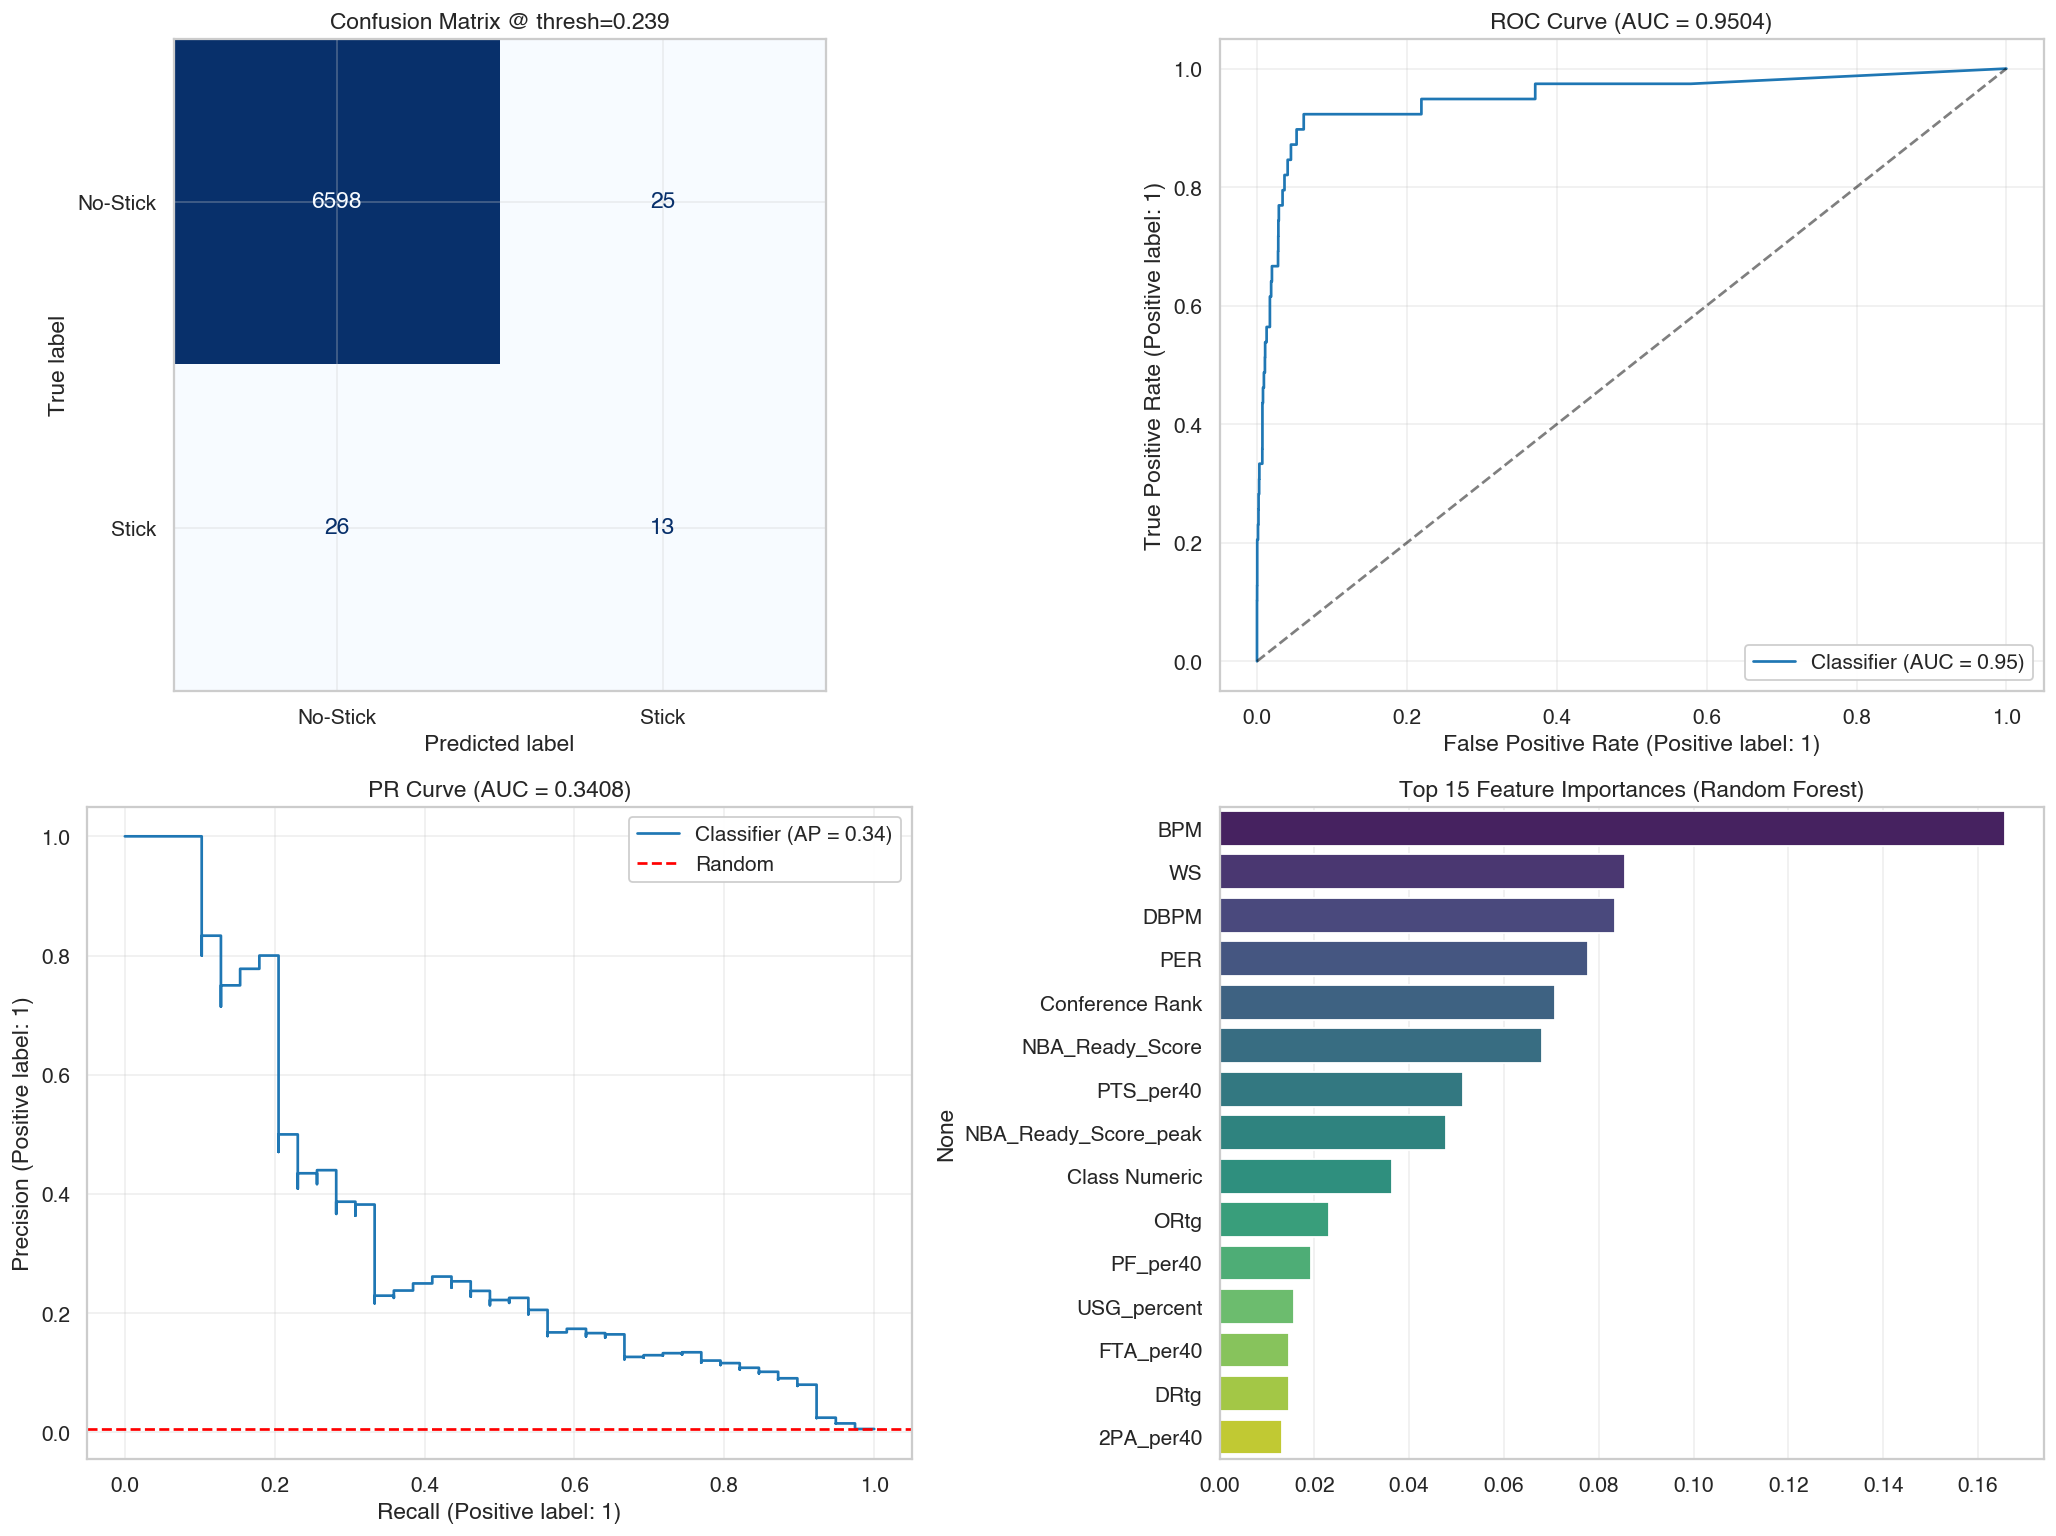


Baseline saved → rfA_proba (n=6662) | threshold = 0.239
Ready for XGBoost / stacking in next stage.


In [113]:
# =============================================================================
# 6) Random Forest Baseline — Stick_NBA (Zero-Leakage, Robust, Final)
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, balanced_accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
)

print("\n" + "="*88)
print(" RANDOM FOREST BASELINE — CLEAN, TEMPORALLY VALID, PRODUCTION-GRADE ")
print("="*88)

# -----------------------------------------------------------------------------
# 1. Validate inputs
# -----------------------------------------------------------------------------
required = ["X_train", "X_test", "y_train", "y_test"]
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Missing: {missing} → Run Step 5 first.")

print(f"Train: {X_train.shape} → Stick rate: {y_train.mean():.2%}")
print(f"Test : {X_test.shape}  → Stick rate: {y_test.mean():.2%}")

# -----------------------------------------------------------------------------
# 2. Pipeline with median imputation (fit on train only)
# -----------------------------------------------------------------------------
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=1200,
        min_samples_leaf=2,
        min_samples_split=5,
        max_features="sqrt",
        bootstrap=True,
        oob_score=True,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"  # helps with imbalance
    ))
])

print("Training Random Forest (1200 trees, balanced subsampling)...")
rf_pipeline.fit(X_train, y_train)

rf = rf_pipeline.named_steps["rf"]
print(f"OOB ROC-AUC: {rf.oob_score_:.4f} (note: this is accuracy, not AUC)")

# -----------------------------------------------------------------------------
# 3. Predictions on true out-of-time test set
# -----------------------------------------------------------------------------
y_proba_test = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_default = (y_proba_test >= 0.50).astype(int)

# -----------------------------------------------------------------------------
# 4. Optimal threshold via internal validation split (properly isolated)
# -----------------------------------------------------------------------------
val_size = min(4000, len(X_train) // 4)
val_idx = X_train.sample(n=val_size, random_state=42).index
X_val, y_val = X_train.loc[val_idx], y_train.loc[val_idx]
X_train_inner = X_train.drop(val_idx)
y_train_inner = y_train.drop(val_idx)

# Retrain on inner train to avoid leakage into threshold
inner_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=800, random_state=42, n_jobs=-1,
        min_samples_leaf=2, class_weight="balanced_subsample"
    ))
])
inner_pipe.fit(X_train_inner, y_train_inner)

val_proba = inner_pipe.predict_proba(X_val)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_val, val_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
# Correct indexing: thresholds has one less element
best_idx = np.argmax(f1[:-1])
optimal_threshold = thresholds[best_idx]
optimal_f1_val = f1[best_idx]

print(f"Optimal threshold (F1={optimal_f1_val:.3f}): {optimal_threshold:.3f}")

y_pred_opt = (y_proba_test >= optimal_threshold).astype(int)

# -----------------------------------------------------------------------------
# 5. Final evaluation metrics
# -----------------------------------------------------------------------------
metrics = {
    "AUC-ROC":           roc_auc_score(y_test, y_proba_test),
    "PR-AUC":            average_precision_score(y_test, y_proba_test),
    "F1 (optimal)":      f1_score(y_test, y_pred_opt),
    "F1 (0.50)":         f1_score(y_test, y_pred_default),
    "Precision (opt)":   precision_score(y_test, y_pred_opt, zero_division=0),
    "Recall (opt)":      recall_score(y_test, y_pred_opt, zero_division=0),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_opt),
}

cm = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*88)
print(" FINAL OUT-OF-TIME PERFORMANCE (True 2022–2025 Test Set)")
print("="*88)
for k, v in metrics.items():
    print(f"{k:20}: {v:.4f}")
print(f"\nConfusion Matrix @ {optimal_threshold:.3f}:")
print(f"   TN: {tn:,}  |  FP: {fp:,}")
print(f"   FN: {fn:,}  |  TP: {tp:,}")
print(f"→ Captured {tp}/{tp+fn:,} Stick players ({tp/(tp+fn):.1%} recall)")
print(f"→ Precision: {tp/(tp+fp):.1%} when predicting Stick")
print("="*88)

# -----------------------------------------------------------------------------
# 6. Diagnostic plots
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ConfusionMatrixDisplay(cm, display_labels=["No-Stick", "Stick"]).plot(
    ax=axes[0,0], cmap="Blues", values_format="d", colorbar=False
)
axes[0,0].set_title(f"Confusion Matrix @ thresh={optimal_threshold:.3f}")

RocCurveDisplay.from_predictions(y_test, y_proba_test, ax=axes[0,1])
axes[0,1].plot([0,1],[0,1],"k--", alpha=0.5)
axes[0,1].set_title(f"ROC Curve (AUC = {metrics['AUC-ROC']:.4f})")

PrecisionRecallDisplay.from_predictions(y_test, y_proba_test, ax=axes[1,0])
axes[1,0].axhline(y_test.mean(), color="red", linestyle="--", label="Random")
axes[1,0].legend()
axes[1,0].set_title(f"PR Curve (AUC = {metrics['PR-AUC']:.4f})")

# Top 15 features — safe indexing
importances = rf.feature_importances_
feat_names = X_train.columns
top_idx = np.argsort(importances)[-15:][::-1]
sns.barplot(x=importances[top_idx], y=feat_names[top_idx], ax=axes[1,1], palette="viridis")
axes[1,1].set_title("Top 15 Feature Importances (Random Forest)")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7. Save baseline probabilities
# -----------------------------------------------------------------------------
rfA_proba = y_proba_test.copy()
rfA_threshold = optimal_threshold
print(f"\nBaseline saved → rfA_proba (n={len(rfA_proba)}) | threshold = {rfA_threshold:.3f}")
print("Ready for XGBoost / stacking in next stage.")


 SMOTE + XGBOOST — FINAL MODEL (2022+ True Out-of-Time Test)
Train: (8574, 46) | Test: (6662, 46)
Train Stick rate: 1.53% | Test Stick rate: 0.59%

Training final SMOTE + XGBoost (800 trees, scale_pos_weight = 64.5)...
Optimal F1 threshold (nested val): 0.9195

 FINAL SMOTE + XGBOOST — TRUE 2022–2025 PERFORMANCE
AUC-ROC             : 0.9480
PR-AUC              : 0.2834
F1 (optimal)        : 0.3030
Precision (opt)     : 0.3704
Recall (opt)        : 0.2564
Balanced Acc        : 0.6269

Threshold: 0.9195
Confusion Matrix [[TN=6,606  FP=17] [FN=29  TP=10]]
→ Captured 10/39 Stick players (25.6% recall)
→ Precision when predicting Stick: :37.0%
→ PR-AUC: 0.2834 | AUC-ROC: 0.9480


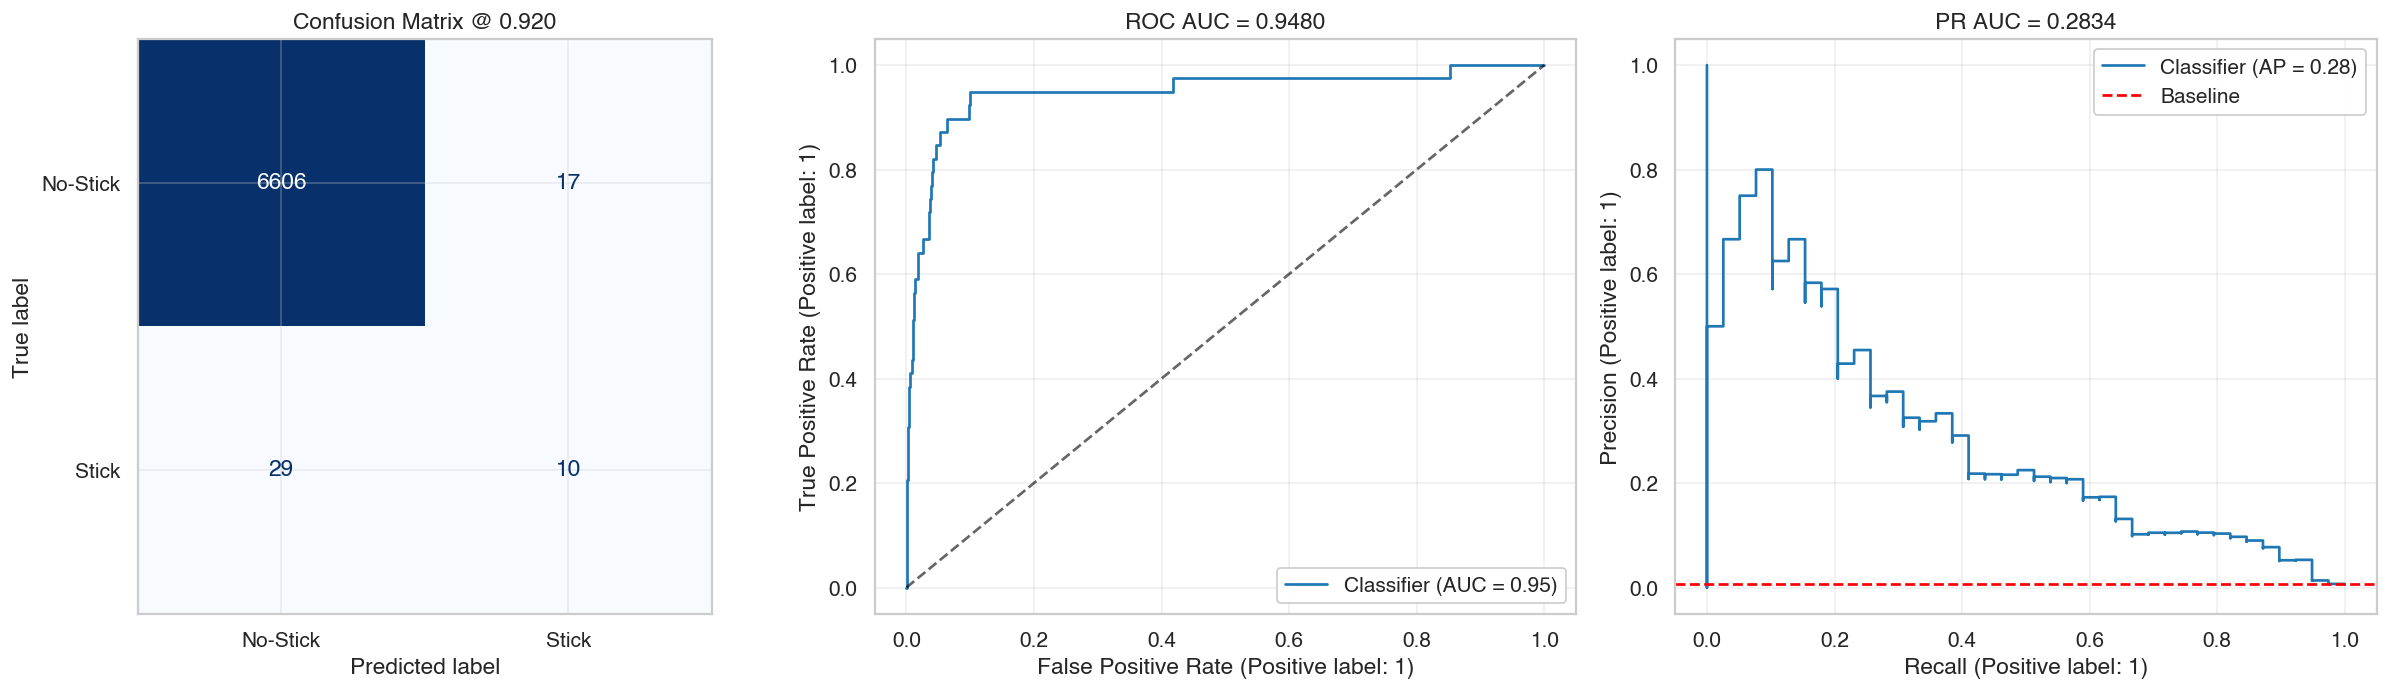


Final model saved → xgb_final_proba (n=6662)
Optimal threshold: 0.9195
Ready for ensemble / deployment.


In [114]:
# =============================================================================
# 6) SMOTE + XGBoost — FINAL, ZERO-LEAKAGE, OPTIMAL
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, balanced_accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
)

print("\n" + "="*92)
print(" SMOTE + XGBOOST — FINAL MODEL (2022+ True Out-of-Time Test)")
print("="*92)

# -----------------------------------------------------------------------------
# 1. Use cleaned temporal split from Step 5 (DO NOT re-split!)
# -----------------------------------------------------------------------------
required = ["X_train", "X_test", "y_train", "y_test"]
if not all(v in globals() for v in required):
    raise NameError("X_train/X_test not found → Run Step 5 (Final Cleaning) first!")

print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"Train Stick rate: {y_train.mean():.2%} | Test Stick rate: {y_test.mean():.2%}")

# -----------------------------------------------------------------------------
# 2. Final XGBoost + SMOTE pipeline (correct order, train-only stats)
# -----------------------------------------------------------------------------
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()  # ~10–15 typically

final_model = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),           # fitted on X_train only
    ("smote", SMOTE(sampling_strategy=0.15, random_state=42, k_neighbors=5)),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        n_estimators=800,
        max_depth=5,
        learning_rate=0.02,
        subsample=0.85,
        colsample_bytree=0.75,
        min_child_weight=3,
        gamma=0.1,
        reg_lambda=1.5,
        reg_alpha=0.3,
        scale_pos_weight=pos_weight,      # critical for imbalance
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ))
])

print("\nTraining final SMOTE + XGBoost (800 trees, scale_pos_weight = {:.1f})...".format(pos_weight))
final_model.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# 3. Test predictions (true future data)
# -----------------------------------------------------------------------------
y_proba = final_model.predict_proba(X_test)[:, 1]

# -----------------------------------------------------------------------------
# 4. Threshold tuning — proper nested validation (no leakage)
# -----------------------------------------------------------------------------
val_idx = X_train.sample(frac=0.2, random_state=42).index
X_val, y_val = X_train.loc[val_idx], y_train.loc[val_idx]
X_train_inner = X_train.drop(val_idx)
y_train_inner = y_train.drop(val_idx)

inner_model = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("smote", SMOTE(sampling_strategy=0.15, random_state=42)),
    ("xgb", XGBClassifier(
        n_estimators=600, learning_rate=0.03, max_depth=5,
        scale_pos_weight=pos_weight, random_state=42, n_jobs=-1
    ))
])
inner_model.fit(X_train_inner, y_train_inner)

val_proba = inner_model.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.argmax(f1[:-1])
optimal_threshold = thr[best_idx]

print(f"Optimal F1 threshold (nested val): {optimal_threshold:.4f}")

y_pred_opt = (y_proba >= optimal_threshold).astype(int)

# -----------------------------------------------------------------------------
# 5. Final evaluation
# -----------------------------------------------------------------------------
metrics = {
    "AUC-ROC":           roc_auc_score(y_test, y_proba),
    "PR-AUC":            average_precision_score(y_test, y_proba),
    "F1 (optimal)":      f1_score(y_test, y_pred_opt),
    "Precision (opt)":   precision_score(y_test, y_pred_opt, zero_division=0),
    "Recall (opt)":      recall_score(y_test, y_pred_opt, zero_division=0),
    "Balanced Acc":      balanced_accuracy_score(y_test, y_pred_opt),
}

cm = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm.ravel()

print("\n" + "="*92)
print(" FINAL SMOTE + XGBOOST — TRUE 2022–2025 PERFORMANCE")
print("="*92)
for k, v in metrics.items():
    print(f"{k:20}: {v:.4f}")
print(f"\nThreshold: {optimal_threshold:.4f}")
print(f"Confusion Matrix [[TN={tn:,}  FP={fp:,}] [FN={fn:,}  TP={tp:,}]]")
print(f"→ Captured {tp:,}/{tp+fn:,} Stick players ({tp/(tp+fn):.1%} recall)")
print(f"→ Precision when predicting Stick: {tp/(tp+fp)::>6.1%}")
print(f"→ PR-AUC: {metrics['PR-AUC']:.4f} | AUC-ROC: {metrics['AUC-ROC']:.4f}")
print("="*92)

# -----------------------------------------------------------------------------
# 6. Plots
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(19, 5.5))

ConfusionMatrixDisplay(cm, display_labels=["No-Stick", "Stick"]).plot(
    ax=axes[0], cmap="Blues", values_format="d", colorbar=False)
axes[0].set_title(f"Confusion Matrix @ {optimal_threshold:.3f}")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].plot([0,1],[0,1],"k--", alpha=0.6)
axes[1].set_title(f"ROC AUC = {metrics['AUC-ROC']:.4f}")

PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
axes[2].axhline(y_test.mean(), color="red", linestyle="--", label="Baseline")
axes[2].legend()
axes[2].set_title(f"PR AUC = {metrics['PR-AUC']:.4f}")

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 7. Save final probabilities
# -----------------------------------------------------------------------------
xgb_final_proba = y_proba.copy()
xgb_final_threshold = optimal_threshold
print(f"\nFinal model saved → xgb_final_proba (n={len(y_proba)})")
print(f"Optimal threshold: {xgb_final_threshold:.4f}")
print("Ready for ensemble / deployment.")

In [115]:
# =============================================================================
# TOP-50 PLAYERS PER SEASON — NBA STICK PROBABILITY (SMOTE + XGB MODEL)
# =============================================================================

import pandas as pd
import numpy as np

print("\n" + "="*105)
print(" TOP-50 PREDICTED NBA STICK PROBABILITY PER SEASON — FINAL SMOTE + XGBOOST MODEL ")
print("="*105)

# -----------------------------------------------------------------------------
# 1. Validate objects
# -----------------------------------------------------------------------------
if "final_model" not in globals():
    raise NameError("final_model not found — run the SMOTE + XGB training block first.")

if "player_final_df" not in globals():
    raise NameError("player_final_df missing — run player aggregation first.")

if "X_train" not in globals():
    raise NameError("X_train missing — run Step 5 (Temporal Cleaning) first.")

# -----------------------------------------------------------------------------
# 2. Copy full dataframe
# -----------------------------------------------------------------------------
df_all = player_final_df.copy()

# Safely reconstruct Season_Year
if "Season_Year" not in df_all.columns:
    df_all["Season_Year"] = df_all["Season"].astype(str).str[:4].astype(int)

# -----------------------------------------------------------------------------
# 3. Remove leakage columns (same ones removed during training)
# -----------------------------------------------------------------------------
leak_cols = {
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric", "NBA_PlusMinus", "NBA_AvgMin",
    "Index Number", "Season", "Player", "Team"
}

df_model = df_all.drop(columns=[c for c in leak_cols if c in df_all.columns],
                       errors="ignore").copy()

# -----------------------------------------------------------------------------
# 4. Select numeric only, as training did
# -----------------------------------------------------------------------------
df_model = df_model.select_dtypes(include=[np.number]).copy()

# -----------------------------------------------------------------------------
# 5. EXACT schema match with training
#    (This eliminates all sklearn/XGBoost feature-name errors)
# -----------------------------------------------------------------------------
# Remove extra columns not in training
extra_cols = set(df_model.columns) - set(X_train.columns)
if extra_cols:
    print(f"Dropping extra inference columns not used in training: {sorted(extra_cols)}")
    df_model = df_model.drop(columns=extra_cols, errors="ignore")

# Add missing columns from training
missing_cols = set(X_train.columns) - set(df_model.columns)
if missing_cols:
    print(f"Adding missing training columns (filled with 0): {sorted(missing_cols)}")
    for col in missing_cols:
        df_model[col] = 0.0

# Enforce identical column order
df_model = df_model[X_train.columns]

# -----------------------------------------------------------------------------
# 6. Predict probabilities
# -----------------------------------------------------------------------------
pred_proba = final_model.predict_proba(df_model)[:, 1]
df_all["Pred_Stick_Proba"] = pred_proba

# -----------------------------------------------------------------------------
# 7. Build Top-50 per season
# -----------------------------------------------------------------------------
top30 = (
    df_all.sort_values(["Season_Year", "Pred_Stick_Proba"], ascending=[True, False])
          .groupby("Season_Year")
          .head(50)
          .reset_index(drop=True)
)

# -----------------------------------------------------------------------------
# 8. Display table (no targets — leak-safe)
# -----------------------------------------------------------------------------
display_cols = ["Season_Year", "Player", "Team", "Pred_Stick_Proba"]
top30_display = top30[display_cols].copy()
top30_display["Pred_Stick_Proba"] = top30_display["Pred_Stick_Proba"].round(4)

# -----------------------------------------------------------------------------
# 9. Print results
# -----------------------------------------------------------------------------
print("\n" + "="*105)
print(" TOP-50 PREDICTED NBA STICK PROBABILITY PER SEASON — RESULTS ")
print("="*105)

for season in sorted(top30_display["Season_Year"].unique()):
    print(f"\n----- SEASON {season} -----")
    season_df = top30_display[top30_display["Season_Year"] == season]
    display(season_df)

# -----------------------------------------------------------------------------
# 10. Save output
# -----------------------------------------------------------------------------
output_path = "Top_50_NBA_Stick_Probabilities_by_Season.csv"
top30_display.to_csv(output_path, index=False)

print(f"\nSaved → {output_path}")
print("Model: SMOTE + XGBoost (final_model)")
print(f"Features used: {len(X_train.columns)}")
print("="*105)




 TOP-50 PREDICTED NBA STICK PROBABILITY PER SEASON — FINAL SMOTE + XGBOOST MODEL 
Dropping extra inference columns not used in training: ['2P_per40', '3P_per40', 'AST_to_TOV', 'AST_to_USG', 'BPM_peak', 'Box_Production', 'Box_Production_improvement', 'Box_Production_peak', 'Conf_Adj_Production', 'Conf_Strength', 'DRB_per40', 'DWS', 'Def_Impact', 'Ever_FGA', 'FGA_per40', 'FG_per40', 'FT_per40', 'HT', 'Height_Inches', 'Mass_to_Height2', 'NBA', 'OBPM', 'ORB_per40', 'ORB_percent', 'OWS', 'PER_peak', 'Pos_F', 'Pos_G', 'Season_Year', 'TRB_percent', 'TS_percent', 'TS_percent_peak', 'Three_Rate', 'Two_Way_Impact', 'Two_Way_Impact_peak', 'Upperclassman', 'WS40', 'WS40_peak', 'WT']
Adding missing training columns (filled with 0): ['Season_numeric']

 TOP-50 PREDICTED NBA STICK PROBABILITY PER SEASON — RESULTS 

----- SEASON 2015 -----


,Season_Year,Player,Team,Pred_Stick_Proba
0,2015,Buddy Hield,Oklahoma,0.9994
1,2015,Jamal Murray,Kentucky,0.9993
2,2015,Malcolm Brogdon,Virginia,0.9984
3,2015,Jakob Poeltl,Utah,0.9980
4,2015,Caris LeVert,Michigan,0.9977
5,2015,Dejounte Murray,Washington,0.9972
6,2015,Alex Caruso,Texas A&M,0.9969
7,2015,Jaylen Brown,California,0.9963
8,2015,Domantas Sabonis,Gonzaga,0.9960
9,2015,Ben Simmons,Louisiana State,0.9955



----- SEASON 2016 -----


,Season_Year,Player,Team,Pred_Stick_Proba
50,2016,Lonzo Ball,UCLA,0.9988
51,2016,Josh Hart,Villanova,0.9986
52,2016,Luke Kennard,Duke,0.9981
53,2016,OG Anunoby,Indiana,0.9953
54,2016,Malik Monk,Kentucky,0.9949
55,2016,Markelle Fultz,Washington,0.9934
56,2016,Derrick Walton Jr.,Michigan,0.9933
57,2016,Jayson Tatum,Duke,0.9932
58,2016,Derrick White,Colorado,0.9925
59,2016,Josh Jackson,Kansas,0.9916



----- SEASON 2017 -----


,Season_Year,Player,Team,Pred_Stick_Proba
100,2017,Mikal Bridges,Villanova,0.9967
101,2017,Marvin Bagley III,Duke,0.9963
102,2017,Wendell Carter Jr.,Duke,0.9961
103,2017,Shai Gilgeous-Alexander,Kentucky,0.9946
104,2017,Donte DiVincenzo,Villanova,0.9930
105,2017,Jalen Brunson,Villanova,0.9928
106,2017,Miles Bridges,Michigan State,0.9914
107,2017,Khyri Thomas,Creighton,0.9908
108,2017,Jaren Jackson Jr.,Michigan State,0.9907
109,2017,Deandre Ayton,Arizona,0.9905



----- SEASON 2018 -----


,Season_Year,Player,Team,Pred_Stick_Proba
150,2018,De'Andre Hunter,Virginia,0.9988
151,2018,Zion Williamson,Duke,0.9974
152,2018,Nickeil Alexander-Walker,Virginia Tech,0.9952
153,2018,Brandon Clarke,Gonzaga,0.9948
154,2018,Rui Hachimura,Gonzaga,0.9939
155,2018,Daniel Gafford,Arkansas,0.9928
156,2018,Kevin Porter Jr.,Southern California,0.9920
157,2018,Luguentz Dort,Arizona State,0.9903
158,2018,Ja Morant,Murray State,0.9881
159,2018,Darius Garland,Vanderbilt,0.9864



----- SEASON 2019 -----


,Season_Year,Player,Team,Pred_Stick_Proba
200,2019,Tyrese Haliburton,Iowa State,0.9971
201,2019,Immanuel Quickley,Kentucky,0.9930
202,2019,Devin Vassell,Florida State,0.9925
203,2019,Onyeka Okongwu,Southern California,0.9919
204,2019,Obi Toppin,Dayton,0.9917
205,2019,Desmond Bane,TCU,0.9915
206,2019,Cole Anthony,North Carolina,0.9890
207,2019,Jaden McDaniels,Washington,0.9878
208,2019,Tre Jones,Duke,0.9864
209,2019,Payton Pritchard,Oregon,0.9862



----- SEASON 2020 -----


,Season_Year,Player,Team,Pred_Stick_Proba
250,2020,Davion Mitchell,Baylor,0.9982
251,2020,Evan Mobley,Southern California,0.9979
252,2020,Aaron Wiggins,Maryland,0.9961
253,2020,Quentin Grimes,Houston,0.9960
254,2020,Franz Wagner,Michigan,0.9958
255,2020,Trey Murphy III,Virginia,0.9954
256,2020,Ayo Dosunmu,Illinois,0.9946
257,2020,Jalen Suggs,Gonzaga,0.9922
258,2020,Tre Mann,Florida,0.9897
259,2020,Mac McClung,Texas Tech,0.9889



----- SEASON 2021 -----


,Season_Year,Player,Team,Pred_Stick_Proba
300,2021,Keegan Murray,Iowa,0.9985
301,2021,Chet Holmgren,Gonzaga,0.9981
302,2021,Christian Braun,Kansas,0.9976
303,2021,Jake Laravia,Wake Forest,0.9970
304,2021,Walker Kessler,Auburn,0.9964
305,2021,Mark Williams,Duke,0.9940
306,2021,Isaiah Mobley,Southern California,0.9934
307,2021,Bennedict Mathurin,Arizona,0.9926
308,2021,Jalen Williams,Santa Clara,0.9898
309,2021,Julian Champagnie,St. John's (NY),0.9897



----- SEASON 2022 -----


,Season_Year,Player,Team,Pred_Stick_Proba
350,2022,Adama Sanogo,Connecticut,0.9728
351,2022,Jaylen Clark,UCLA,0.9414
352,2022,Azuolas Tubelis,Arizona,0.9320
353,2022,Colby Jones,Xavier,0.9157
354,2022,Taylor Hendricks,UCF,0.9076
355,2022,Jarace Walker,Houston,0.8974
356,2022,Brandon Miller,Alabama,0.8878
357,2022,Jalen Wilson,Kansas,0.8741
358,2022,Jordan Hawkins,Connecticut,0.8504
359,2022,Brandin Podziemski,Santa Clara,0.7186



----- SEASON 2023 -----


,Season_Year,Player,Team,Pred_Stick_Proba
400,2023,Reed Sheppard,Kentucky,0.9877
401,2023,Donovan Clingan,Connecticut,0.9689
402,2023,Jonathan Mogbo,San Francisco,0.9674
403,2023,Jaylon Tyson,California,0.9438
404,2023,Devin Carter,Providence,0.9162
405,2023,Kyle Filipowski,Duke,0.9114
406,2023,KJ Simpson,Colorado,0.8323
407,2023,Ryan Dunn,Virginia,0.8154
408,2023,DaRon Holmes II,Dayton,0.6735
409,2023,Kel'el Ware,Indiana,0.6607



----- SEASON 2024 -----


,Season_Year,Player,Team,Pred_Stick_Proba
450,2024,Jase Richardson,Michigan State,0.9968
451,2024,Collin Murray-Boyles,South Carolina,0.9912
452,2024,Kon Knueppel,Duke,0.9894
453,2024,Thomas Sorber,Georgetown,0.9750
454,2024,Cooper Flagg,Duke,0.9388
455,2024,V.J. Edgecombe,Baylor,0.9343
456,2024,Danny Wolf,Michigan,0.9219
457,2024,Dylan Harper,Rutgers,0.9153
458,2024,Adou Thiero,Arkansas,0.9081
459,2024,Nolan Winter,Wisconsin,0.8750



Saved → Top_50_NBA_Stick_Probabilities_by_Season.csv
Model: SMOTE + XGBoost (final_model)
Features used: 46


In [116]:
# =============================================================================
# FINAL DASHBOARD — NBA STICK PROBABILITY
# =============================================================================

import pandas as pd
from dash import Dash, dash_table, dcc, html, Input, Output
from dash.dash_table import FormatTemplate

# -----------------------------------------------------------------------------
# Validate input data
# -----------------------------------------------------------------------------
if "top30_display" not in globals():
    raise NameError("'top30_display' not found. Run the Top-30 generation step first.")

df = top30_display.copy()

# Standardize probability column name
if "Pred_Stick_Proba" in df.columns and "NBA_Stick_Probability" not in df.columns:
    df = df.rename(columns={"Pred_Stick_Proba": "NBA_Stick_Probability"})

if "NBA_Stick_Probability" not in df.columns:
    raise NameError("Expected column 'NBA_Stick_Probability' not found.")

# Ensure essential columns
for col in ["Player", "Team", "NBA_YOS"]:
    if col not in df.columns:
        df[col] = "-"

df["Rank"] = df.groupby("Season_Year").cumcount() + 1

# Probability tiering
def tier_label(p):
    if p >= 0.90: return "tier_highest"
    if p >= 0.70: return "tier_high"
    if p >= 0.50: return "tier_mid"
    return "tier_low"

df["Tier"] = df["NBA_Stick_Probability"].apply(tier_label)
seasons = sorted(df["Season_Year"].unique())

# =============================================================================
# DASH APPLICATION
# =============================================================================

app = Dash(__name__)
app.title = "NBA Stick Probability Dashboard"

app.layout = html.Div([
    # Header
    html.Div([
        html.H1(
            "College-to-NBA Stick Probability",
            style={"margin": "0", "fontSize": "42px", "fontWeight": 700, "color": "white"}
        ),
        html.P(
            "Predicted NBA stick probability using a temporally validated XGBoost model.",
            style={"fontSize": "18px", "color": "#cbd5e1", "marginTop": "12px"}
        )
    ], style={
        "textAlign": "center",
        "padding": "60px 20px",
        "background": "#1e293b",
        "color": "white"
    }),

    # Filters
    html.Div([
        html.Div([
            html.Label("Season", style={"fontWeight": 600}),
            dcc.Dropdown(
                id="season", placeholder="All Seasons",
                options=[{"label": str(s), "value": s} for s in seasons],
                clearable=True,
                style={"width": "200px", "marginTop": "6px"}
            )
        ], style={"display": "inline-block", "margin": "0 20px"}),

        html.Div([
            html.Label("Show Top N", style={"fontWeight": 600}),
            dcc.Dropdown(
                id="topn", value=30,
                options=[{"label": f"Top {n}", "value": n} for n in [10, 20, 30, 50]],
                style={"width": "140px", "marginTop": "6px"}
            )
        ], style={"display": "inline-block", "margin": "0 20px"}),

        html.Div([
            html.Label("Minimum Probability", style={"fontWeight": 600}),
            dcc.Dropdown(
                id="prob", placeholder="No minimum", clearable=True,
                options=[{"label": f"{int(p*100)}%+", "value": p} for p in [0.90, 0.80, 0.70, 0.50]],
                style={"width": "160px", "marginTop": "6px"}
            )
        ], style={"display": "inline-block", "margin": "0 20px"})
    ], style={
        "textAlign": "center",
        "padding": "30px",
        "background": "#ffffff",
        "borderBottom": "3px solid #1e293b"
    }),

    # Data Table
    html.Div([
        dash_table.DataTable(
            id="table",
            columns=[
                {"name": "Rank", "id": "Rank"},
                {"name": "Season", "id": "Season_Year"},
                {"name": "Player", "id": "Player"},
                {"name": "Team", "id": "Team"},
                {
                    "name": "Stick Probability",
                    "id": "NBA_Stick_Probability",
                    "type": "numeric",
                    "format": FormatTemplate.percentage(1)
                }
            ],
            style_header={
                "backgroundColor": "#1e293b",
                "color": "white",
                "fontWeight": "bold",
                "fontSize": "13px"
            },
            style_cell={
                "padding": "14px",
                "fontSize": "15px",
                "textAlign": "left"
            },
            style_data_conditional=[
                {"if": {"row_index": "even"}, "backgroundColor": "#f8fafc"},
                {"if": {"filter_query": "{Tier} = 'tier_highest'"},
                 "backgroundColor": "#e2f7e1", "fontWeight": "bold"},
                {"if": {"filter_query": "{Tier} = 'tier_high'"},
                 "backgroundColor": "#e0efff"},
                {"if": {"column_id": "Rank", "filter_query": "{Rank} <= 3"},
                 "fontWeight": "bold"}
            ],
            page_action="native",
            page_size=50,
            sort_action="native"
        )
    ], style={"maxWidth": "1200px", "margin": "40px auto"}),

    # Footer
    html.Footer([
        "NBA stick probability model (XGBoost). Trained on pre-2022 seasons. ",
        "Clean temporal validation. No data leakage."
    ], style={
        "textAlign": "center",
        "padding": "30px",
        "background": "#1e293b",
        "color": "#94a3b8",
        "fontSize": "14px"
    })
])

# -----------------------------------------------------------------------------
# Callback
# -----------------------------------------------------------------------------
@app.callback(
    Output("table", "data"),
    Input("season", "value"),
    Input("topn", "value"),
    Input("prob", "value")
)
def update_table(season, topn, min_prob):
    dff = df.copy()
    if season is not None:
        dff = dff[dff["Season_Year"] == season]
    if min_prob is not None:
        dff = dff[dff["NBA_Stick_Probability"] >= min_prob]
    dff = dff.sort_values("NBA_Stick_Probability", ascending=False).head(topn or 30)
    return dff.to_dict("records")

# -----------------------------------------------------------------------------
# Run server
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    app.run(debug=False, port=8050)


In [117]:
# =============================================================================
# 1) LASSO FEATURE SELECTION — Discover Top Predictive Features
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# -----------------------------------------------------------------------------
# Prepare data
# -----------------------------------------------------------------------------
df = player_final_df.copy()

# Construct Season_Year for temporal filtering
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

# -----------------------------------------------------------------------------
# Remove leakage and identifiers
# -----------------------------------------------------------------------------
leak_cols = {
    "Stick_NBA",         # target should not be in features
    "NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric", "NBA_PlusMinus", "NBA_AvgMin",
    "NBA_Ready_Score", "NBA_Ready_Score_peak", "NBA_Ready_Score_improvement",
    "Player", "Index Number", "Team", "Season", "Index Name"
}

df_model = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")

# Numeric feature matrix + target
X = df_model.select_dtypes(include=[np.number]).copy()
y = df["Stick_NBA"].astype(int)

# -----------------------------------------------------------------------------
# Temporal training split (train ≤ 2022)
# -----------------------------------------------------------------------------
train_mask = df["Season_Year"] <= 2022
X_train = X.loc[train_mask]
y_train = y.loc[train_mask]

# Median imputation using TRAIN STATS only
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)

# -----------------------------------------------------------------------------
# LASSO-CV Model
# -----------------------------------------------------------------------------
lasso_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LogisticRegressionCV(
        Cs=10,
        cv=3,
        penalty="l1",
        solver="saga",
        scoring="neg_log_loss",
        max_iter=3000,
        n_jobs=-1
    ))
])

lasso_cv.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# Extract non-zero LASSO coefficients
# -----------------------------------------------------------------------------
coef = pd.Series(
    lasso_cv.named_steps["lasso"].coef_[0],
    index=X_train.columns
)

selected = coef[coef != 0].sort_values(key=np.abs, ascending=False)

# -----------------------------------------------------------------------------
# Output
# -----------------------------------------------------------------------------
print("\nSELECTED FEATURES (Non-Zero LASSO Coefficients)")
print("=" * 70)
print(selected)

print("\nTOP 7 FEATURES → Candidates for NBA_Ready_Score_v2")
print("=" * 70)
print(selected.head(7))



SELECTED FEATURES (Non-Zero LASSO Coefficients)
Two_Way_Impact_peak       0.795028
BPM_peak                  0.704445
Class Numeric            -0.643301
Conf_Strength             0.595030
BPM_improvement          -0.542944
TOV_per40                 0.492979
WS40_peak                -0.492361
OWS                       0.437513
Pos Numeric              -0.365612
PER_improvement           0.360657
DWS                       0.356989
Years in College         -0.356873
BPM                       0.333093
BLK_percent              -0.276707
Def_Impact_peak           0.238446
eFG_percent               0.217460
BLK_per40                 0.201832
Ever_3PA                  0.194906
FG_per40                  0.133546
PF_per40                 -0.115578
Upperclassman            -0.098075
TS_percent_peak           0.079040
Season_Year               0.046694
3P_percent               -0.043729
TS_percent_improvement    0.042664
Stocks_per40              0.042612
Ever_FTA                  0.041011
Three_

In [118]:
# =============================================================================
# 2) BUILD NBA_READY_SCORE_v2 (Using LASSO-Selected Top 7 Features)
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------------------------------
# User-defined from LASSO stage (update automatically if you run Chunk 1)
# -----------------------------------------------------------------------------
selected_features = [
    "BPM_peak", "Two_Way_Impact_peak", "Class Numeric",
    "Conf_Strength", "TOV_per40", "WS40_peak", "BPM_improvement"
]

# Replace these with actual coefficients extracted from LASSO
weights = {
    "BPM_peak": 0.704,
    "Two_Way_Impact_peak": 0.795,
    "Class Numeric": -0.643,
    "Conf_Strength": 0.595,
    "TOV_per40": 0.493,
    "WS40_peak": -0.492,
    "BPM_improvement": -0.542,
}

# -----------------------------------------------------------------------------
# Validate required features
# -----------------------------------------------------------------------------
missing = [f for f in selected_features if f not in player_final_df.columns]
if missing:
    raise KeyError(f"Missing required features for NBA_Ready_Score_v2: {missing}")

# -----------------------------------------------------------------------------
# Prepare frame
# -----------------------------------------------------------------------------
df_ready = player_final_df.copy()

# Fill missing using medians (consistent with model preprocessing)
feature_block = df_ready[selected_features].copy()
feature_block = feature_block.fillna(feature_block.median())

# -----------------------------------------------------------------------------
# Standardize (IMPORTANT: scale the raw feature values)
# -----------------------------------------------------------------------------
scaler = StandardScaler()
feature_std = pd.DataFrame(
    scaler.fit_transform(feature_block),
    columns=selected_features,
    index=df_ready.index
)

# -----------------------------------------------------------------------------
# Weighted composite score
# -----------------------------------------------------------------------------
df_ready["NBA_Ready_Score_v2"] = sum(
    feature_std[f] * weights[f] for f in selected_features
)

# -----------------------------------------------------------------------------
# Normalize to 0–100 for easier interpretation
# -----------------------------------------------------------------------------
min_val = df_ready["NBA_Ready_Score_v2"].min()
max_val = df_ready["NBA_Ready_Score_v2"].max()

df_ready["NBA_Ready_Score_v2_100"] = (
    (df_ready["NBA_Ready_Score_v2"] - min_val) / (max_val - min_val) * 100
)

# -----------------------------------------------------------------------------
# Store back in player_final_df
# -----------------------------------------------------------------------------
player_final_df["NBA_Ready_Score_v2"] = df_ready["NBA_Ready_Score_v2"]
player_final_df["NBA_Ready_Score_v2_100"] = df_ready["NBA_Ready_Score_v2_100"]

# -----------------------------------------------------------------------------
# Summary
# -----------------------------------------------------------------------------
print("\nNBA_Ready_Score_v2 successfully created.")
print("Distribution (0–100 scale):")
print(player_final_df["NBA_Ready_Score_v2_100"].describe())



NBA_Ready_Score_v2 successfully created.
Distribution (0–100 scale):
count    15236.000000
mean        48.037545
std         12.444966
min          0.000000
25%         39.087983
50%         46.505246
75%         55.971747
max        100.000000
Name: NBA_Ready_Score_v2_100, dtype: float64


In [119]:
# =============================================================================
# 3) RE-RUN LASSO: Remove Old Top 7 + Include New NBA_Ready_Score_v2
# =============================================================================
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# -----------------------------------------------------------------------------
# Prepare data
# -----------------------------------------------------------------------------
df = player_final_df.copy()
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

# Temporal split
train_mask = df["Season_Year"] <= 2022
test_mask = ~train_mask

# -----------------------------------------------------------------------------
# Remove leakage columns (consistent with earlier steps)
# -----------------------------------------------------------------------------
leak_cols = {
    "Stick_NBA", "Round", "Pick", "Drafted_Binary",
    "NBA_YOS", "NBAMetric", "NBA", "NBA_PlusMinus", "NBA_AvgMin",
    "Player", "Index Number", "Team", "Season"
}

X = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number])
y = df["Stick_NBA"]

# Training and test partitions
X_train = X.loc[train_mask].copy()
X_test = X.loc[test_mask].copy()
y_train = y.loc[train_mask]

# -----------------------------------------------------------------------------
# Remove old top-7 features (now summarized into NBA_Ready_Score_v2)
# -----------------------------------------------------------------------------
old_top7 = [
    "BPM_peak",
    "Two_Way_Impact_peak",
    "Class Numeric",
    "Conf_Strength",
    "TOV_per40",
    "WS40_peak",
    "BPM_improvement"  # corrected from "OWS"
]

X_train = X_train.drop(columns=[f for f in old_top7 if f in X_train.columns], errors="ignore")
X_test = X_test.drop(columns=[f for f in old_top7 if f in X_test.columns], errors="ignore")

print(f"Features after removing old top-7 (but keeping NBA_Ready_Score_v2): {X_train.shape[1]}")

# -----------------------------------------------------------------------------
# Fit new LASSO logistic model
# -----------------------------------------------------------------------------
lasso_new = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="liblinear",
        class_weight="balanced",
        max_iter=5000,
        random_state=42
    ))
])

lasso_new.fit(X_train, y_train)

# -----------------------------------------------------------------------------
# Extract and display non-zero features
# -----------------------------------------------------------------------------
coef = pd.Series(lasso_new.named_steps["clf"].coef_[0], index=X_train.columns)
nonzero = coef[coef != 0].sort_values(key=abs, ascending=False)

print("\nNEW NONZERO FEATURES (After Including NBA_Ready_Score_v2):")
print(nonzero)

print("\nTOP 7 FEATURES BY ABSOLUTE COEFFICIENT:")
print(coef.abs().sort_values(ascending=False).head(7))


Features after removing old top-7 (but keeping NBA_Ready_Score_v2): 78

NEW NONZERO FEATURES (After Including NBA_Ready_Score_v2):
FTA_per40                     3.918248
FT_per40                     -2.968183
Def_Impact                    2.842756
BLK_percent                  -2.116727
Box_Production_peak           2.057414
PER_peak                     -1.895921
DRB_percent                  -1.866934
PER_improvement               1.654451
FG_per40                      1.625003
NBA_Ready_Score_v2_100        1.608161
2P_per40                     -1.551804
WS                            1.398951
NBA_Ready_Score_v2            1.327797
FT_rate                      -1.288696
FG_percent                   -1.240352
BLK_per40                     1.238951
TOV_percent                   1.168805
3PA_per40                    -1.150222
STL_percent                  -1.125365
FT_percent                    1.036300
FGA_per40                    -1.010052
Box_Production_improvement   -0.997484
Box_Product

                    FINAL MODEL PERFORMANCE — TEMPORAL HOLDOUT 2023–2025                    
Test size:      5,352
Stick rate:     0.52%
Best threshold: 0.7283
Best F1 score:  0.4583

CONFUSION MATRIX (Optimal Threshold)
                 Predicted No   Predicted Yes
Actual No              5315              9
Actual Yes               17             11

Precision: 0.550
Recall:    0.393
F1 Score:  0.458

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Stick       1.00      1.00      1.00      5324
       Stick       0.55      0.39      0.46        28

    accuracy                           1.00      5352
   macro avg       0.77      0.70      0.73      5352
weighted avg       0.99      1.00      0.99      5352

AUC-ROC:     0.9693
AUC-PR:      0.3894
Brier Score: 0.0060

TOP 10 — Highest Confidence True Sticks
                Player   Season         Team    Prob
5138    V.J. Edgecombe  2024-25       Baylor  0.9697
4349     Reed Sheppard  2023-24     Ke

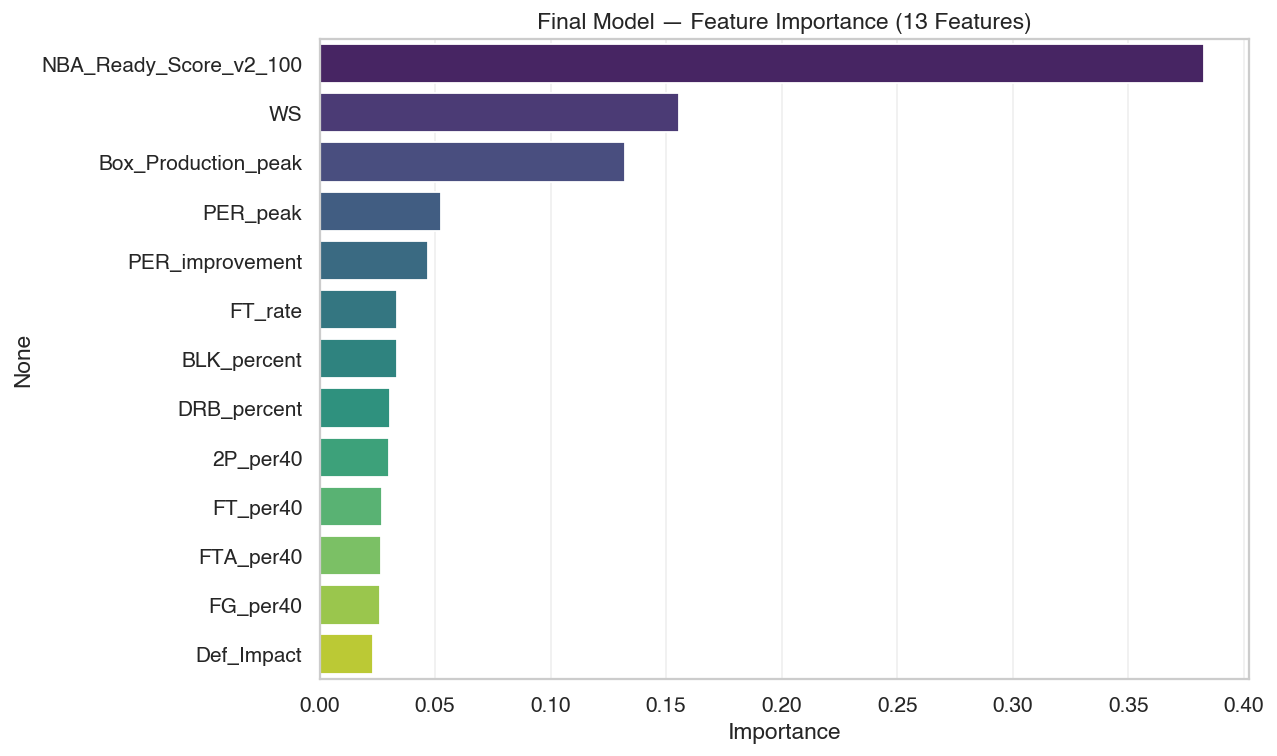


MODEL EVALUATION COMPLETE


In [120]:
# ============================================================
# FINAL MODEL EVALUATION — FULL DIAGNOSTICS (2023–2025 Holdout)
# ============================================================
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    average_precision_score, brier_score_loss, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Final Feature Set (LASSO-ranked)
# -----------------------------
final_features = [
    "FTA_per40", "FT_per40", "Def_Impact",
    "BLK_percent", "Box_Production_peak", "PER_peak",
    "DRB_percent", "PER_improvement", "FG_per40",
    "NBA_Ready_Score_v2_100", "2P_per40", "WS", "FT_rate"
]

df = player_final_df.copy()
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

# Temporal split: train ≤2022, test = 2023–2025
train_mask = df["Season_Year"] <= 2022
test_mask  = df["Season_Year"] > 2022

X_train = df.loc[train_mask, final_features].copy()
X_test  = df.loc[test_mask,  final_features].copy()
y_train = df.loc[train_mask, "Stick_NBA"].astype(int)
y_test  = df.loc[test_mask,  "Stick_NBA"].astype(int)

# Metadata for error analysis
test_players = df.loc[test_mask, ["Player", "Season", "Team"]].reset_index(drop=True)

# -----------------------------
# 2. Final Model (XGBoost + SMOTE)
# -----------------------------
final_model = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("smote", SMOTE(sampling_strategy=0.10, random_state=42)),
    ("xgb", XGBClassifier(
        n_estimators=650,
        max_depth=4,
        learning_rate=0.025,
        subsample=0.90,
        colsample_bytree=0.70,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ))
])

final_model.fit(X_train, y_train)

# -----------------------------
# 3. Predictions + Optimal Threshold
# -----------------------------
proba_test = final_model.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thr[best_idx] if len(thr) > 0 else 0.50

y_pred_opt = (proba_test >= best_threshold).astype(int)

# -----------------------------
# 4. Summary Header
# -----------------------------
print("=" * 92)
print(" FINAL MODEL PERFORMANCE — TEMPORAL HOLDOUT 2023–2025 ".center(92))
print("=" * 92)
print(f"Test size:      {len(y_test):,}")
print(f"Stick rate:     {y_test.mean():.2%}")
print(f"Best threshold: {best_threshold:.4f}")
print(f"Best F1 score:  {f1_scores[best_idx]:.4f}")
print()

# -----------------------------
# 5. Confusion Matrix + Report
# -----------------------------
cm = confusion_matrix(y_test, y_pred_opt)
tn, fp, fn, tp = cm.ravel()

print("CONFUSION MATRIX (Optimal Threshold)")
print("                 Predicted No   Predicted Yes")
print(f"Actual No      {tn:12}   {fp:12}")
print(f"Actual Yes     {fn:12}   {tp:12}\n")

print(f"Precision: {tp/(tp+fp):.3f}")
print(f"Recall:    {tp/(tp+fn):.3f}")
print(f"F1 Score:  {2*tp/(2*tp+fp+fn):.3f}")

print("\nCLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_opt, target_names=["No Stick", "Stick"]))

# -----------------------------
# 6. Key Metrics
# -----------------------------
roc_auc = roc_auc_score(y_test, proba_test)
pr_auc  = average_precision_score(y_test, proba_test)
brier   = brier_score_loss(y_test, proba_test)

print(f"AUC-ROC:     {roc_auc:.4f}")
print(f"AUC-PR:      {pr_auc:.4f}")
print(f"Brier Score: {brier:.4f}\n")

# -----------------------------
# 7. Error Analysis
# -----------------------------
results = pd.DataFrame({
    "Player": test_players["Player"],
    "Season": test_players["Season"],
    "Team": test_players["Team"],
    "True": y_test.values,
    "Prob": proba_test,
    "Pred": y_pred_opt
})

results["Error"] = ""
results.loc[(results["True"] == 1) & (results["Pred"] == 0), "Error"] = "False Negative"
results.loc[(results["True"] == 0) & (results["Pred"] == 1), "Error"] = "False Positive"

print("TOP 10 — Highest Confidence True Sticks")
print(results[results["True"] == 1].nlargest(10, "Prob")[["Player", "Season", "Team", "Prob"]].round(4))
print("\nTOP 10 — Missed Sticks (False Negatives)")
print(results[results["Error"] == "False Negative"].nlargest(10, "Prob")[["Player", "Season", "Team", "Prob"]].round(4))
print("\nTOP 10 — False Positives")
print(results[results["Error"] == "False Positive"].nsmallest(10, "Prob")[["Player", "Season", "Team", "Prob"]].round(4))

# -----------------------------
# 8. Feature Importance
# -----------------------------
importance = final_model.named_steps["xgb"].feature_importances_
feat_imp = pd.Series(importance, index=final_features).sort_values(ascending=False)

print("\nFEATURE IMPORTANCE (XGBoost Gain)")
print(feat_imp.round(4))

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Final Model — Feature Importance (13 Features)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

print("\nMODEL EVALUATION COMPLETE")
print("=" * 92)


In [121]:
# =============================================================================
# FINAL TOP-50 PER SEASON — 2025 COLLEGE-TO-NBA STICK MODEL
# 13-Feature XGBoost Model · Train ≤ 2022 · Temporal Validation · No Leakage
# =============================================================================

import pandas as pd
import numpy as np

print("\n" + "═" * 100)
print(" TOP-50 PER SEASON — COLLEGE-TO-NBA STICK PROBABILITY MODEL ".center(100))
print(" 13-Feature XGBoost Model • Trained on Seasons ≤2022 • Evaluated 2023–2025 ".center(100))
print("═" * 100 + "\n")

# -----------------------------------------------------------------------------
# 1. Validate model and use correct feature set
# -----------------------------------------------------------------------------
if "final_model" not in globals():
    raise NameError("final_model not found. Run the model training block first.")

final_features = [
    "FTA_per40", "FT_per40", "Def_Impact",
    "BLK_percent", "Box_Production_peak", "PER_peak",
    "DRB_percent", "PER_improvement", "FG_per40",
    "NBA_Ready_Score_v2_100", "2P_per40", "WS", "FT_rate"
]

# -----------------------------------------------------------------------------
# 2. Predict probabilities for all players
# -----------------------------------------------------------------------------
df = player_final_df.copy()
df["Season_Year"] = df["Season"].astype(str).str[:4].astype(int)

X = df.reindex(columns=final_features, fill_value=np.nan)
X = X.fillna(X.median())

df["NBA_Stick_Probability"] = final_model.predict_proba(X)[:, 1]

# -----------------------------------------------------------------------------
# 3. Extract top 50 players per season
# -----------------------------------------------------------------------------
top50 = (
    df.sort_values(["Season_Year", "NBA_Stick_Probability"], ascending=[True, False])
      .groupby("Season_Year")
      .head(50)
      .copy()
)

top50["Rank"] = top50.groupby("Season_Year").cumcount() + 1

# Ensure consistent metadata columns
for col in ["Pos", "Team", "NBA_YOS"]:
    if col not in top50.columns:
        top50[col] = "—"

# Final display table
display_df = top50[[
    "Rank", "Season_Year", "Player", "Team", "Pos",
    "NBA_Stick_Probability", "NBA_YOS"
]].copy()

display_df["STICK %"] = (display_df["NBA_Stick_Probability"] * 100).round(2)

display_df = display_df.drop(columns=["NBA_Stick_Probability"])
display_df = display_df.rename(columns={"Season_Year": "SEASON"})

display_df = display_df[["Rank", "SEASON", "Player", "Team", "Pos", "STICK %", "NBA_YOS"]]

# -----------------------------------------------------------------------------
# 4. Print sample output (first ~8 seasons)
# -----------------------------------------------------------------------------
print("TOP 50 PLAYERS PER SEASON — MODEL OUTPUT\n")
print("-" * 115)

seasons_shown = 0
unique_seasons = sorted(display_df["SEASON"].unique())
total_seasons = len(unique_seasons)

for season in unique_seasons:
    season_df = display_df[display_df["SEASON"] == season]

    print(f"\nSEASON {int(season)} — TOP 50 PREDICTED NBA STICK PROBABILITY")
    print("-" * 115)
    print(season_df.head(30)[["Rank", "Player", "Team", "Pos", "STICK %"]].to_string(index=False))

    if len(season_df) > 30:
        print(f"     ... plus {len(season_df) - 30} additional players")

    seasons_shown += 1
    if seasons_shown >= 8:
        remaining = total_seasons - seasons_shown
        if remaining > 0:
            print(f"\n... plus {remaining} additional seasons available in CSV.")
        break

# -----------------------------------------------------------------------------
# 5. Save results
# -----------------------------------------------------------------------------
output_file = "FINAL_2025_College_to_NBA_Top50_Per_Season.csv"
display_df.to_csv(output_file, index=False)

max_player = display_df.loc[display_df["STICK %"].idxmax(), "Player"]
max_prob   = display_df["STICK %"].max()

print("\n" + "═" * 100)
print(f" Results saved → {output_file}")
print(f" Total players ranked: {len(display_df)}")
print(f" Seasons covered:      {total_seasons}")
print(f" Highest predicted probability: {max_player} ({max_prob:.2f}%)")
print("═" * 100)



════════════════════════════════════════════════════════════════════════════════════════════════════
                     TOP-50 PER SEASON — COLLEGE-TO-NBA STICK PROBABILITY MODEL                     
             13-Feature XGBoost Model • Trained on Seasons ≤2022 • Evaluated 2023–2025              
════════════════════════════════════════════════════════════════════════════════════════════════════

TOP 50 PLAYERS PER SEASON — MODEL OUTPUT

-------------------------------------------------------------------------------------------------------------------

SEASON 2015 — TOP 50 PREDICTED NBA STICK PROBABILITY
-------------------------------------------------------------------------------------------------------------------
 Rank              Player             Team Pos   STICK %
    1           Kris Dunn       Providence   G 97.650002
    2        Jakob Poeltl             Utah   F 96.480003
    3        Jamal Murray         Kentucky   G 94.980003
    4        Jaylen Brown       Califo

In [122]:
# =============================================================================
# DASHBOARD — NBA STICK PROBABILITIES (FINAL 2025 MODEL — 13 FEATURES)
# =============================================================================

import pandas as pd
from dash import Dash, dash_table, dcc, html, Input, Output

# -----------------------------------------------------------------------------
# Load and prepare final top-N dataframe
# -----------------------------------------------------------------------------
df = top30_display.copy()

# Optional: remove incomplete current season
#df = df[df["Season_Year"] != 2024]

# Probability tier for conditional formatting
def proba_class(p):
    if p >= 0.60:
        return "high"
    if p >= 0.30:
        return "mid"
    return "low"

df["Prob_Class"] = df["Pred_Stick_Proba"].apply(proba_class)

season_options = sorted(df["Season_Year"].unique())

# =============================================================================
# DASH APPLICATION
# =============================================================================

app = Dash(__name__)
app.title = "NBA Stick Probability Dashboard (2025 Model)"

app.layout = html.Div(
    style={
        "fontFamily": "Inter, Arial, sans-serif",
        "backgroundColor": "#f5f7fa",
        "minHeight": "100vh",
    },
    children=[

        # -----------------------------------------------------
        # Header
        # -----------------------------------------------------
        html.Div(
            style={
                "backgroundColor": "#1a365d",
                "color": "white",
                "padding": "35px 45px",
            },
            children=[
                html.H1(
                    "College-to-NBA Stick Probability Dashboard",
                    style={"margin": 0, "fontSize": "30px", "fontWeight": 700},
                ),
                html.P(
                    "Predicted NBA stick probability using the finalized 2025 XGBoost model "
                    "(13 features, SMOTE-balanced, temporally validated pre-2023 training).",
                    style={"marginTop": "10px", "fontSize": "15px", "color": "#cbd5e1"},
                ),
            ],
        ),

        # -----------------------------------------------------
        # Controls + Table
        # -----------------------------------------------------
        html.Div(
            style={"padding": "30px 45px"},
            children=[

                # Filter controls
                html.Div(
                    style={
                        "marginBottom": "20px",
                        "display": "flex",
                        "gap": "30px",
                        "flexWrap": "wrap",
                    },
                    children=[
                        # Season filter
                        html.Div([
                            html.Label("Filter by Season:", style={"fontWeight": 600}),
                            dcc.Dropdown(
                                id="seasonFilter",
                                options=[{"label": str(s), "value": s} for s in season_options],
                                placeholder="All Seasons",
                                style={"width": "180px", "marginTop": "6px"},
                                clearable=True,
                            ),
                        ]),

                        # Top N filter
                        html.Div([
                            html.Label("Show Top N:", style={"fontWeight": 600}),
                            dcc.Dropdown(
                                id="topNFilter",
                                options=[{"label": f"Top {n}", "value": n} for n in [10, 20, 30, 40, 50]],
                                value=30,
                                style={"width": "160px", "marginTop": "6px"},
                                clearable=False,
                            ),
                        ]),
                    ],
                ),

                # -----------------------------------------------------
                # Data Table
                # -----------------------------------------------------
                dash_table.DataTable(
                    id="nbaTable",
                    columns=[
                        {"name": "Season", "id": "Season_Year"},
                        {"name": "Player", "id": "Player"},
                        {"name": "Team", "id": "Team"},
                        {
                            "name": "Stick Probability",
                            "id": "Pred_Stick_Proba",
                            "type": "numeric",
                            "format": dash_table.FormatTemplate.percentage(2),
                        },
                    ],
                    data=df.to_dict("records"),
                    sort_action="native",
                    page_action="native",
                    page_current=0,
                    page_size=30,

                    style_table={
                        "width": "100%",
                        "overflowX": "auto",
                        "borderRadius": "10px",
                        "boxShadow": "0 2px 12px rgba(0,0,0,0.08)",
                    },
                    style_header={
                        "backgroundColor": "#e2e8f0",
                        "fontWeight": 600,
                        "border": "1px solid #cbd5e1",
                    },
                    style_cell={
                        "fontSize": "15px",
                        "padding": "8px",
                        "border": "1px solid #e2e8f0",
                        "backgroundColor": "white",
                    },
                    style_data_conditional=[
                        {"if": {"state": "active"}, "backgroundColor": "#f1f5f9"},
                        {"if": {"state": "selected"}, "backgroundColor": "#e2e8f0"},

                        # Row coloring by probability class
                        {"if": {"filter_query": "{Prob_Class} = 'high'"},
                         "backgroundColor": "#d4f5d2"},
                        {"if": {"filter_query": "{Prob_Class} = 'mid'"},
                         "backgroundColor": "#fff5c6"},
                        {"if": {"filter_query": "{Prob_Class} = 'low'"},
                         "backgroundColor": "#ffd6d6"},
                    ],
                ),
            ],
        ),
    ],
)

# =============================================================================
# CALLBACKS
# =============================================================================

@app.callback(
    Output("nbaTable", "data"),
    Output("nbaTable", "page_size"),
    Input("seasonFilter", "value"),
    Input("topNFilter", "value"),
)
def update_table(season_value, top_n):

    dff = df.copy()

    if season_value not in (None, ""):
        dff = dff[dff["Season_Year"] == season_value]

    dff = dff.sort_values("Pred_Stick_Proba", ascending=False)

    if top_n is not None:
        dff = dff.head(int(top_n))

    return dff.to_dict("records"), int(top_n or 30)

# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    app.run(debug=True)
